In [16]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)
import ipywidgets as widgets
from IPython.display import display



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
# Get one wf in particular
wf_idx = 0
wf = wf_list[wf_idx][0]
fs = wf_list[wf_idx][1]
wf_title = wf_list[wf_idx][2]
del df

Loading Curated Data
Combining into one Dataframe!


In [ ]:
"Calculate asymmetric comparison"
tauS = 2**11
tau = tauS / 44100
min_xi = 0.0025
max_xi = tau / 4
num_xis = 50
rho=1

# Calculate xi and frequency arrays
xis = np.linspace(min_xi, max_xi, num_xis)
f = rfftfreq(tauS, 1/fs)
    
# Make sure we have a consistent number of segments to take vector strength over since this will change with xi
max_xiS = max(xis) * fs
N_segs = int((len(wf) - tauS) / max_xiS)    
    
# Initialize coherences array
reg_coherences = np.zeros((len(f), len(xis)))
asym_coherences = np.zeros((len(f), len(xis)))
asym_double_coherences = np.zeros((len(f), len(xis)))

plt.close('all')
# Calculate coherences
for i, xi in enumerate(xis):
    reg_coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
    asym_coherences[:, i] = get_asym_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, rho=rho, N_segs=N_segs, double_fft=False)[1]
    asym_double_coherences[:, i] = get_asym_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, rho=rho, N_segs=N_segs, double_fft=True)[1]
    


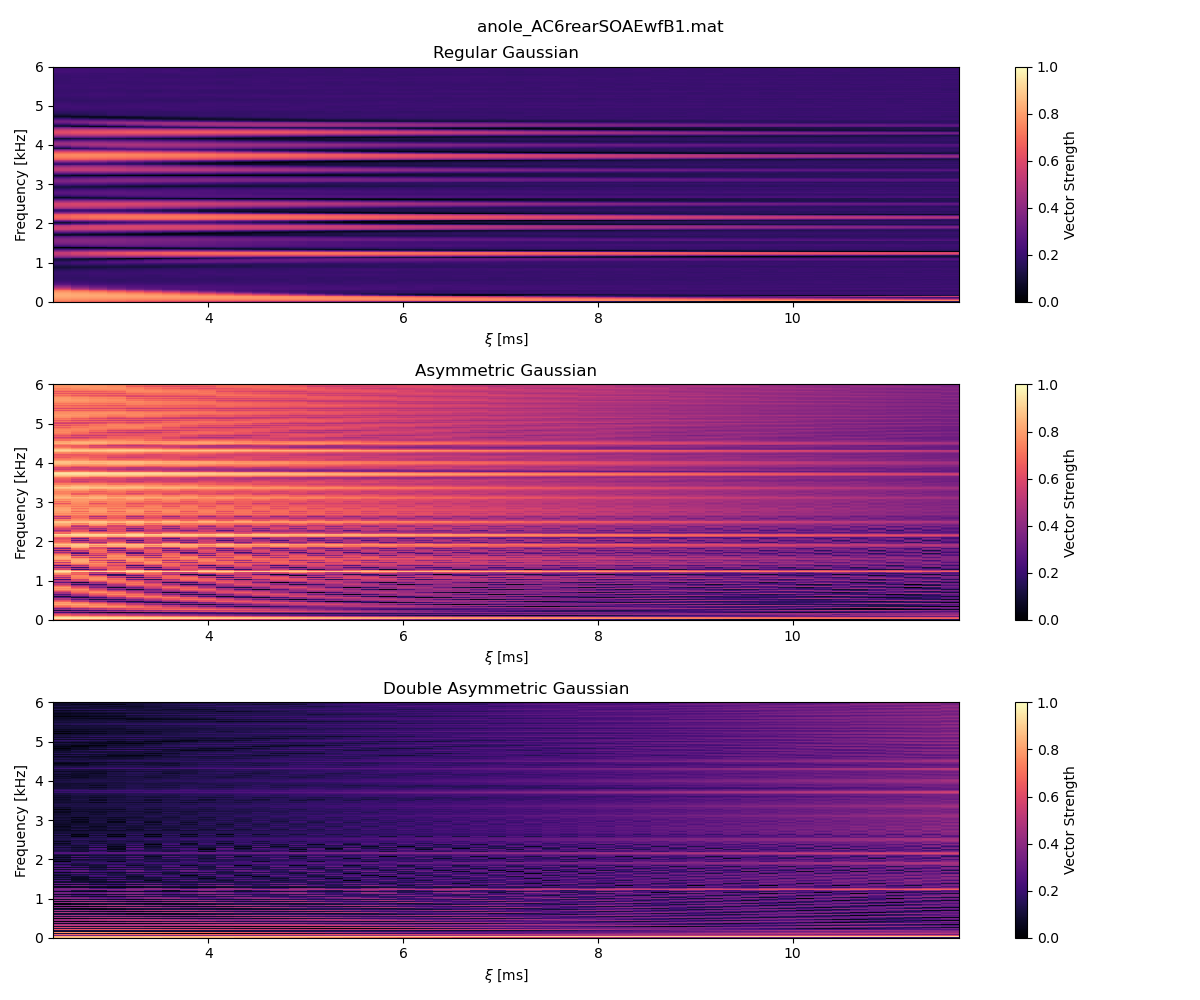

In [ ]:
"Plot asymmetric comparison"
plt.close('all')
plt.figure(figsize=(12, 10))
for i, (coherences, title) in enumerate(zip([reg_coherences, asym_coherences, asym_double_coherences], ["Regular Gaussian", "Asymmetric Gaussian", "Double Asymmetric Gaussian"])):
    plt.subplot(3, 1, i + 1)
    max_khz = 6
    plot_colossogram(coherences, f, xis, tau, title=title, max_khz=max_khz, cmap='magma')
plt.suptitle(wf_title)
plt.tight_layout()
plt.savefig(f'asym_colossogram_comparison_lizard.png', dpi=300)
plt.show()

In [ ]:
# Subtracting Background Noise?
tauS = 2**11
tau = tauS / fs
xi = tau / 10

f, coherence = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg")
f, coherence_sigma = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", rho=1)

plt.close('all')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(f, coherence, label='No Window')
plt.plot(f, coherence_sigma, label='Gaussian')
plt.ylim(-0.5, 1)
plt.xlim(0, 10000)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(f, coherence - 0.8, label='No Window (floor subtracted)')
plt.plot(f, coherence_sigma - 0.2, label='Gaussian (floor subtracted)')
plt.ylim(-0.5, 1)
plt.xlim(0, 10000)
plt.legend()
plt.show()